In [20]:
import polars as pl
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import pycountry
from datetime import datetime

In [35]:
selected_country = "FI"
date = 2021
date_range=range(2016,2022)

In [22]:
df = pl.scan_parquet("../../data/edges")
df = df.with_columns(pl.col("Date").str.to_date())
df = df.filter(pl.col("source_country") == selected_country).group_by([pl.col("target_country"),pl.col("Date").dt.year()]).len()
print(df.limit(3).collect())

shape: (3, 3)
┌────────────────┬──────┬─────┐
│ target_country ┆ Date ┆ len │
│ ---            ┆ ---  ┆ --- │
│ str            ┆ i32  ┆ u32 │
╞════════════════╪══════╪═════╡
│ YE             ┆ 2021 ┆ 6   │
│ north america  ┆ 2016 ┆ 3   │
│ DK             ┆ 2017 ┆ 106 │
└────────────────┴──────┴─────┘


In [43]:
world = gpd.read_file("../../data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

df_p = df.collect().to_pandas()
world_m = world.merge(df_p, left_on='ISO_A2_EH', right_on='target_country')


/tmp/ipykernel_6123/1476494568.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("GnBu")


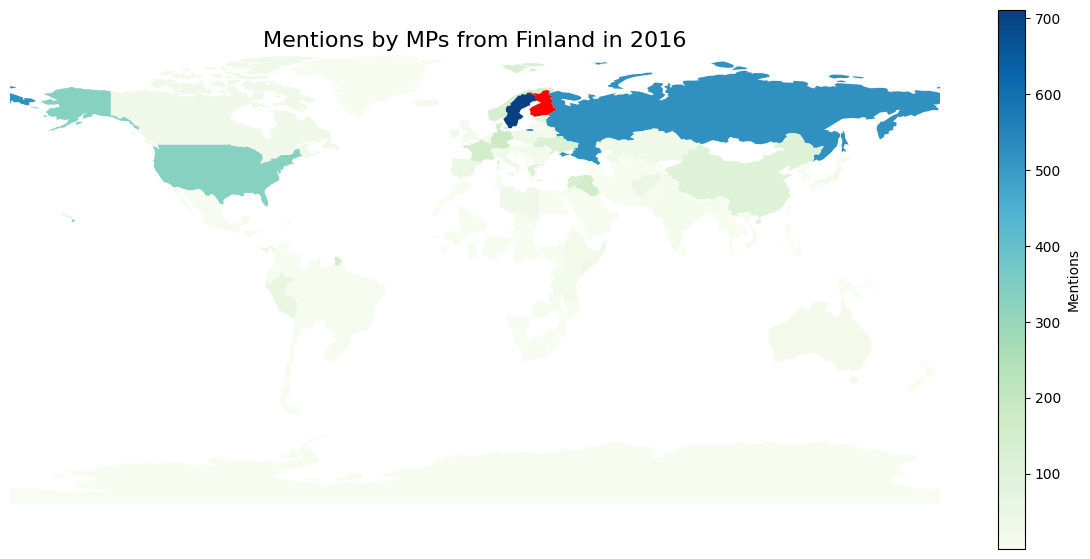

In [61]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors


cmap = cm.get_cmap("GnBu")
norm = colors.Normalize(vmin=world_m["len"].min(), vmax=world_m["len"].max())
xmin, ymin, xmax, ymax = world.total_bounds

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=ax, label="Mentions")

country = world[world['ISO_A2_EH'] == selected_country]
country.plot(ax=ax, color='red')

def update(frame_date):
    ax.clear()

    world_m_a = world_m[world_m["Date"] == frame_date]

    world_m_a.plot(column='len', ax=ax, cmap='GnBu',legend=False, missing_kwds={"color": "lightgrey", "label": "No data"})

    country.plot(ax=ax, color='red')

    ax.set_aspect('equal')
    country_name = world[world['ISO_A2_EH'] == selected_country]["NAME"].iloc[0]
    ax.set_title(f'Mentions by MPs from {country_name} in {frame_date}', fontdict={'fontsize': 16})
    ax.set_axis_off()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)


ani = FuncAnimation(fig, update, frames=date_range, repeat=False)

ani.save('mentions_animation.gif', writer='pillow', fps=1)  # Increase fps for faster playback


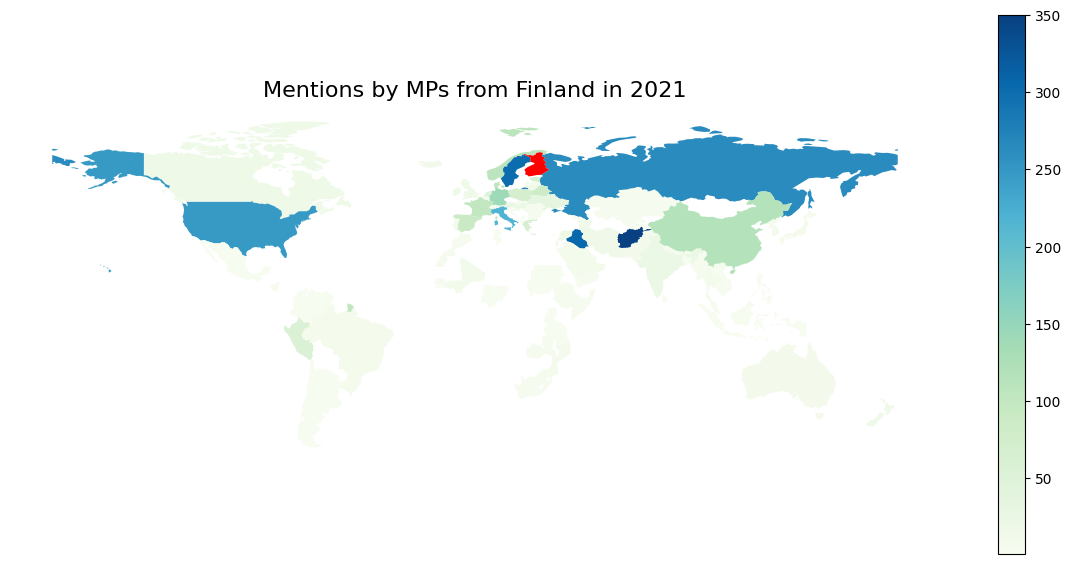

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
world_m_a = world_m[world_m["Date"] == date]
world_m_a.plot(column='len', ax=ax, legend=True, cmap='GnBu', 
           missing_kwds={"color": "lightgrey", "label": "No data"})

country = world[world['ISO_A2_EH'] == selected_country]
country.plot(ax=ax, color='red')
ax.set_aspect('equal')
ax.set_title(f'Mentions by MPs from {world[world['ISO_A2_EH'] == selected_country]["NAME"].iloc[0]} in {date}', fontdict={'fontsize': 16})
ax.set_axis_off()
plt.show()

